This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Recipe #2: Reading and visualizing an ODIM_H5 polar volume

This recipe shows how extract the polar volume data from an ODIM_H5 hdf5 file (KNMI example file from OPERA), contruct a 3-dimensional Cartesian volume and produce a diagnostic plot. The challenge for this file is that for each elevation angle, the scan strategy is different.

In [1]:
import wradlib as wrl
import xarray as xr
import xradar as xd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
import numpy as np

In [2]:
import datetime as dt
from osgeo import osr

# read the data (sample file in WRADLIB_DATA)
filename = wrl.util.get_wradlib_data_file("hdf5/knmi_polar_volume.h5")

raw_dt = xd.io.open_odim_datatree(filename)
display(raw_dt)

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2011-06-10T11:40:02Z'
│       time_coverage_end    <U20 '2011-06-10T11:43:54Z'
│       longitude            float32 4.79
│       altitude             float32 50.0
│       latitude             float32 52.95
│   Attributes:
│       Conventions:      ODIM_H5/V2_0
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 360, range: 320)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2011-06-10T11:40:17.361118208...
│         * range              (range) float32 500.0 1.5e+03 ... 3.185e+05 3.195e+05
│           longitude          float32 ...
│           latitude           float32 ...
│           altitude           float32 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float32 ...
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 360, range: 240)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2011-06-10T11:40:36.805558272...
│         * range              (range) float32 500.0 1.5e+03 ... 2.385e+05 2.395e+05
│           longitude          float32 ...
│           latitude           float32 ...
│           altitude           float32 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float32 ...
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 360, range: 240)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2011-06-10T11:40:56.305557504...
│         * range              (range) float32 500.0 1.5e+03 ... 2.385e+05 2.395e+05
│           longitude          float32 ...
│           latitude           float32 ...
│           altitude           float32 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float32 ...
├── DataTree('sweep_3')
│       Dimensions:            (azimuth: 360, range: 240)
│       Coordinates:
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2011-06-10T11:41:15.805556736...
│         * range              (range) float32 500.0 1.5e+03 ... 2.385e+05 2.395e+05
│           longitude          float32 ...
│           latitude           float32 ...
│           altitude           float32 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode        

In [3]:
proj = osr.SpatialReference()
proj.ImportFromEPSG(32632)
for key in list(raw_dt.children):
    if "sweep" in key:
        raw_dt[key].ds = raw_dt[key].ds.wrl.georef.georeference(crs=proj)

In [4]:
swp_list = []
for key in list(raw_dt.children):
    if "sweep" in key:
        ds = raw_dt[key].ds
        xyz = (
            xr.concat(
                [
                    ds.coords["x"].reset_coords(drop=True),
                    ds.coords["y"].reset_coords(drop=True),
                    ds.coords["z"].reset_coords(drop=True),
                ],
                "xyz",
            )
            .stack(npoints=("azimuth", "range"))
            .transpose(..., "xyz")
        )
        swp_list.append(xyz)
xyz = xr.concat(swp_list, "npoints")

In [5]:
swp_list[0]

<xarray.DataArray 'x' (npoints: 115200, xyz: 3)>
array([[2.17262259e+05, 5.87587733e+06, 5.30000000e+01],
       [2.17329665e+05, 5.87687562e+06, 5.80000000e+01],
       [2.17397078e+05, 5.87787390e+06, 6.40000000e+01],
       ...,
       [2.33423523e+05, 6.19241547e+06, 7.64800000e+03],
       [2.33475527e+05, 6.19341275e+06, 7.69100000e+03],
       [2.33527539e+05, 6.19441006e+06, 7.73400000e+03]])
Coordinates:
  * npoints  (npoints) object MultiIndex
  * azimuth  (npoints) float32 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
  * range    (npoints) float32 500.0 1.5e+03 2.5e+03 ... 3.185e+05 3.195e+05
Dimensions without coordinates: xyz

In [6]:
data_list = []
for key in list(raw_dt.children):
    if "sweep" in key:
        ds = raw_dt[key].ds
        data = ds.DBZH.stack(npoints=("azimuth", "range"))
        data_list.append(data)
data = xr.concat(data_list, "npoints")

In [7]:
# generate 3-D Cartesian target grid coordinates
sitecoords = (raw_dt.longitude.values, raw_dt.latitude.values, raw_dt.altitude.values)
maxrange = 200000.0
minelev = 0.1
maxelev = 25.0
maxalt = 5000.0
horiz_res = 2000.0
vert_res = 250.0
trgxyz, trgshape = wrl.vpr.make_3d_grid(
    sitecoords, proj, maxrange, maxalt, horiz_res, vert_res
)

In [8]:
# interpolate to Cartesian 3-D volume grid
tstart = dt.datetime.now()
gridder = wrl.vpr.CAPPI(
    xyz.values,
    trgxyz,
    # gridshape=trgshape,
    maxrange=maxrange,
    minelev=minelev,
    maxelev=maxelev,
)
vol = np.ma.masked_invalid(gridder(data.values).reshape(trgshape))
print("3-D interpolation took:", dt.datetime.now() - tstart)

3-D interpolation took: 0:00:01.495383


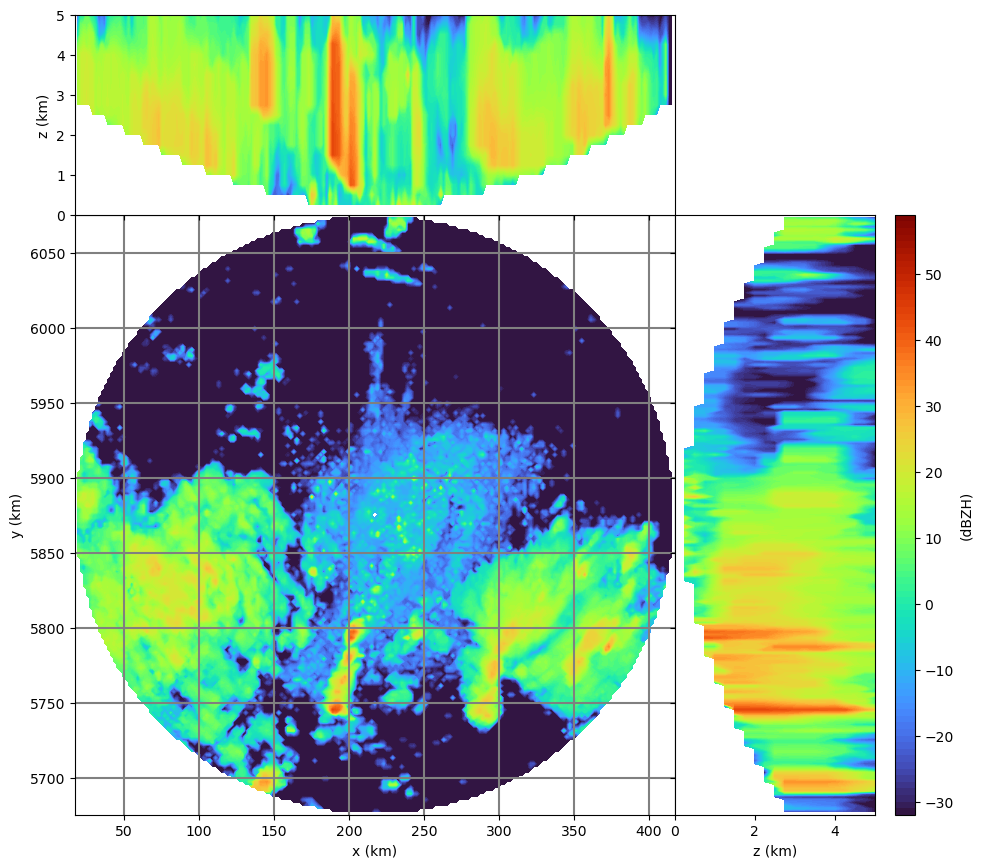

In [9]:
# diagnostic plot
trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]
wrl.vis.plot_max_plan_and_vert(
    trgx,
    trgy,
    trgz,
    vol,
    unit="dBZH",
    levels=range(-32, 60),
    cmap="turbo",
)

<div class="alert alert-info">

**Note** <br>

In order to run the recipe code, you need to extract the sample data into a directory pointed to by environment variable ``WRADLIB_DATA``.
</div>